In [1]:
import pandas as pd
import numpy as np
from datetime import date
import matplotlib.pyplot as plt
import doctest

In [28]:
# data source: 
# TODO: function to read csv
# put csv in "__init__ main" to execute
def load_flu_file(file: str) -> pd.DataFrame:
    """
    Load flu data
    :param file: the name of the file
    :return: a flu data in a data frame format
    """
    flu_df = pd.read_csv(file, header = 2)
    # print(flu_df)
    return flu_df

In [3]:
# data source: https://trends.google.com/trends/explore?date=2019-01-01%202020-10-27&geo=US&q=mask
# TODO: function to analyze mask google trend
# read and clean
def load_mask_file(file: str) -> pd.DataFrame:
    """
    Load mask search trend data
    :param file: the name of the file
    :return: a mask search trend data in a data frame format
    """
    new_header = ['Date', 'mask_interested_in_percentage']
    mask_df = pd.read_csv(file, header = 1, names = new_header)
    return mask_df

In [4]:
# data source: https://www.ecdc.europa.eu/en/publications-data/download-todays-data-geographic-distribution-covid-19-cases-worldwide
# TODO: function to analyze covid case
# read and clean

covid = pd.read_excel('COVID-19-worldwide.xlsx')
covid
# covid.groupby(["year", "month"]).sum()["cases"]

# 變成dataframe然後取出個國家的確認數&日期
# 看要不要group by年、月

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2019,continentExp,Cumulative_number_for_14_days_of_COVID-19_cases_per_100000
0,2020-11-23,23,11,2020,252,8,Afghanistan,AF,AFG,38041757.0,Asia,6.655844
1,2020-11-22,22,11,2020,154,12,Afghanistan,AF,AFG,38041757.0,Asia,6.203709
2,2020-11-21,21,11,2020,232,25,Afghanistan,AF,AFG,38041757.0,Asia,6.130106
3,2020-11-20,20,11,2020,282,5,Afghanistan,AF,AFG,38041757.0,Asia,5.672714
4,2020-11-19,19,11,2020,0,0,Afghanistan,AF,AFG,38041757.0,Asia,5.036571
...,...,...,...,...,...,...,...,...,...,...,...,...
57422,2020-03-25,25,3,2020,0,0,Zimbabwe,ZW,ZWE,14645473.0,Africa,NaN
57423,2020-03-24,24,3,2020,0,1,Zimbabwe,ZW,ZWE,14645473.0,Africa,NaN
57424,2020-03-23,23,3,2020,0,0,Zimbabwe,ZW,ZWE,14645473.0,Africa,NaN
57425,2020-03-22,22,3,2020,1,0,Zimbabwe,ZW,ZWE,14645473.0,Africa,NaN


In [5]:
def get_covid_cases(country_name: str) -> pd.Series:
    """
    Get the new covid cases of each month in a given country's data.
    :param country_name: a string of a country name
    :return: a Pandas Series contained year-month and the sum of the new cases
    >>> get_covid_cases("US").values[11]
    3199482
    >>> get_covid_cases("US").values[1]
    6
    >>> get_covid_cases("UK").values[11]
    522300
    """
    
    if country_name == "US":
        country_name = "United_States_of_America"
    elif country_name == "UK":
        country_name = "United_Kingdom"
    country = covid.loc[covid["countriesAndTerritories"] == country_name]
    # country_new = country.groupby(["year", "month"]).sum()["cases"]
    # print(df)
    country["yearmonth"] = country["dateRep"].map(lambda dt: dt.replace(day=1))
    country_new = country.groupby(["yearmonth"]).sum()["cases"]
    return country_new



In [6]:
# columns we want: year, month, ALL_INF, mask google trend
# TODO: function to make a separte column of datetime
# and then group by 1. year and 2. month (2 conditions)   ('ALL_INF')



In [7]:
def get_total_flu_case_by_month(file: pf.DataFrame) -> pd.Series:
    """
    Get the total flu case of every month
    :param file: file of flu data
    :return: a Pandas Series contained year-month and the sum of the flu cases by month
    >>> d = {"EDATE":['2015-01-04', '2015-01-11', '2015-01-18'], "ALL_INF":(2400, 3314, 3319)}
    >>> df = pd.DataFrame(data=d)
    >>> get_total_flu_case_by_month(df)['2015-01-01']
    9033
    >>> d2 = {"EDATE":['2020-11-01', '2020-11-08', '2020-11-15', '2020-11-22'], "ALL_INF":(9, 5, 15, 12)}
    >>> df2 = pd.DataFrame(data=d2)
    >>> get_total_flu_case_by_month(df2)['2020-11-01']
    41
    """
    
    file["yearmonth"] = pd.to_datetime(file["EDATE"]).map(lambda dt: dt.replace(day=1))
    file_new = file.groupby(["yearmonth"]).sum()["ALL_INF"]
    return file_new

In [8]:
def get_mask_search_trend_by_month(file: pd.DataFrame) -> pd.Series:
    """
    Get the mean mask search trend of every month
    :param file: file of the mask search trend data
    :return: a Pandas Series contained year-month and the mean of the mask search trend by month
    """

    file["yearmonth"] = pd.to_datetime(file["Date"]).map(lambda dt: dt.replace(day=1))
    file_new = file.groupby(["yearmonth"]).mean()["mask_interested_in_percentage"]
    return file_new

In [9]:
# aggregrate everything by country
# columns: year, month, mask, flu, covid
def aggregrate_data(flu_data: pd.Series, mask_data: pd.Series, covid_cases:pd.Series, country_name: str) -> pd.DataFrame:
    """
    Combine all the data we need in a new data frame
    :param flu_data: flu data we extracted and group by year and month
    :param mask_data: mask search trend we got, which are grouped by year and month
    :param: covid_cases: covid cases we got, which are grouped by year and month
    :param country_name: name of the country indicating which data we are going to use
    :return: a new data frame with all the useful data we need
    """
    merge = pd.concat([flu_data, mask_data, covid_cases], axis = 1).reset_index()
    merge["year"] = merge["yearmonth"].dt.year
    merge["month"] = merge["yearmonth"].dt.month
    merge["country"] = country_name
    merge = merge[["year", "month", "yearmonth", "country", "ALL_INF", "mask_interested_in_percentage", "cases"]]
    merge = merge.rename(columns = {"ALL_INF": "flu cases"})
    return merge

In [81]:
def extract_info(country: str) -> pd.DataFrame:
    """
    Extract useful information from a given country name
    :param country: country name that we want to get data from
    :return: a new data frame with all the useful data we need
    """
    flu = "FluNetInteractiveReport_" + country + ".csv"
    mask = "multiTimeline_" + country + ".csv"
    
    fludata = load_flu_file(flu)
    mask_trend = load_mask_file(mask)
    fludata_new = get_total_flu_case_by_month(fludata)
    mask_trend_new = get_mask_search_trend_by_month(mask_trend)
    covid_case = get_covid_cases(country)
    #print(fludata_new)
    result_data = aggregrate_data(fludata_new, mask_trend_new, covid_case, country)
    # print(type(fludata))
    return result_data
    

In [11]:
def separate_data(data, year: int) -> pd.DataFrame:
    """
    Separate and get the data by a given year
    :param data: indicateing which country's data we want to separate
    :param year: indicateing we need the data from which year
    :return: a new data frame from a given year
    >>> separate_data(us, 2020).values[1][0]
    2020
    """
    
    data_new = data.loc[data["year"] == year]
    return data_new

In [62]:
# Data visualization
def plot_graph(country: pd.DataFrame, startyear: int, currentyear: int, status: int):
    """
    Create plots for hypothesis one and two
    :param country: the country's data we need
    :param startyear: the first plot is from the data in startyear
    :param currentyear: the last plot is from the data in currentyear
    :param status: which kind of plot we need(ex: status = 1: plots for the hypothesis 1)
    :return: None
    """
    for year in range(startyear, currentyear + 1):
    
        plot_data = separate_data(country, year) # extract data from specific year
        covidcase=plot_data['cases']
        flucase=plot_data['flu cases']
        mask_trend = plot_data["mask_interested_in_percentage"]
        fig, ax1 = plt.subplots()
        plt.title(country["country"][0] + str(year))
        plt.xlabel('month')
        time=plot_data['month']
        plt.xticks(np.arange(min(time), max(time)+1, 1.0))
        ax2 = ax1.twinx()

        if status == 1:
            yaxis_ax1 = flucase
            yaxis_ax2 = mask_trend
            ax1.set_ylabel('num. of cases', color='black')
            ylabel_ax2 = 'mask trend'
            ax2.set_yticks(range(1, 101, 10))
            ax2.set_ylim([1,100])
        elif status == 2:
            yaxis_ax1 = covidcase
            yaxis_ax2 = flucase
            ax1.set_ylabel('num. of covid cases', color='black')
            ylabel_ax2 = 'num. of flu cases'

        ax1.plot(time, yaxis_ax1, color='black')
        ax2.set_ylabel(ylabel_ax2, color='red')
        ax2.plot(time, yaxis_ax2, color='red')
        ax1.tick_params(axis='y', labelcolor='black')
        ax2.tick_params(axis='y', labelcolor='red')
        fig.tight_layout()

        plt.show()

In [82]:
# if __name__ == "__main__":
# files
"""
flu_china = 'FluNetInteractiveReport_China.csv'
flu_usa = 'FluNetInteractiveReport_US.csv'
flu_uk = 'FluNetInteractiveReport_UK.csv'
mask_china = 'multiTimeline_China.csv'
mask_usa = 'multiTimeline_US.csv'
mask_uk = 'multiTimeline_UK.csv'
"""

china = extract_info("China")
us = extract_info("US")
uk = extract_info("UK")
uk

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


<ipython-input-5-314ff369ee6a>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country["yearmonth"] = country["dateRep"].map(lambda dt: dt.replace(day=1))


,year,month,yearmonth,country,flu cases,mask_interested_in_percentage,cases
0,2015,1,2015-01-01,UK,1460.0,NaN,NaN
1,2015,2,2015-02-01,UK,1863.0,NaN,NaN
2,2015,3,2015-03-01,UK,1062.0,NaN,NaN
3,2015,4,2015-04-01,UK,530.0,NaN,NaN
4,2015,5,2015-05-01,UK,228.0,NaN,NaN
...,...,...,...,...,...,...,...
66,2020,7,2020-07-01,UK,3.0,71.25,18760.0
67,2020,8,2020-08-01,UK,6.0,33.80,32166.0
68,2020,9,2020-09-01,UK,11.0,32.25,111689.0
69,2020,10,2020-10-01,UK,NaN,29.50,543589.0


In [30]:
separate_data(us, 2020)

,year,month,yearmonth,country,flu cases,mask_interested_in_percentage,cases
60,2020,1,2020-01-01,US,75582.0,11.25,6.0
61,2020,2,2020-02-01,US,96058.0,16.75,60.0
62,2020,3,2020-03-01,US,55735.0,41.40,164554.0
63,2020,4,2020-04-01,US,700.0,70.75,875289.0
64,2020,5,2020-05-01,US,194.0,42.80,730475.0
65,2020,6,2020-06-01,US,84.0,42.75,820168.0
66,2020,7,2020-07-01,US,61.0,53.50,1904462.0
67,2020,8,2020-08-01,US,62.0,33.80,1502149.0
68,2020,9,2020-09-01,US,85.0,27.00,1193898.0
69,2020,10,2020-10-01,US,39.0,27.25,1856366.0


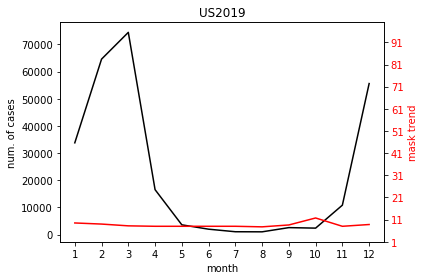

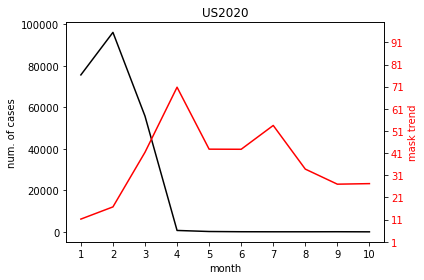

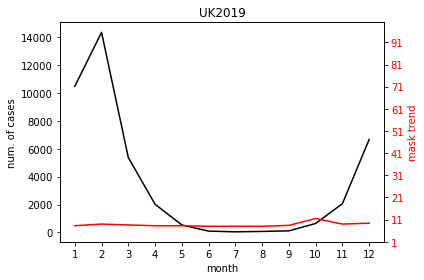

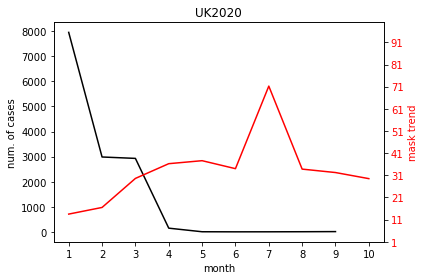

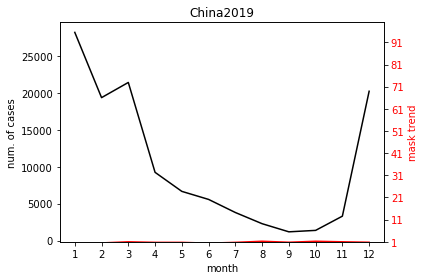

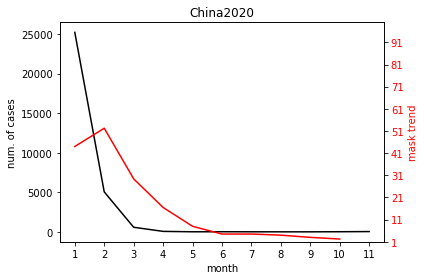

In [68]:
#Hypothesis 1:
#During the pandemic, the global influenza cases may decrease, because people
# wear face masks everywhere.
# hypothesis 1 -> 把2019和2020年分開兩張圖，比較flu cases變化 (flu+口罩的線) -> 作結論 (plot x 6)
us_graph2019=plot_graph(us, 2019, 2020, 1)

uk_graph2019=plot_graph(uk, 2019, 2020, 1)

china_graph2019=plot_graph(china, 2019, 2020, 1)

# flu應該和溫度變化比較有相關，不管口罩搜尋量有沒有增加，flu到夏天時都會好轉。
# However,注意到2019-12和2020-12，因為2020有covid，所以流感沒有回升

In [16]:
#Hypothesis 2:
#In countries where the COVID-19 is abating, the confirmed cases of influenza
# may be increased, since people start not to wear face masks.
# hypothesis 2 -> 把covid跟flu的線畫在一張圖中，分三個國家 -> 作結論 (plot x 3) (2019~2020)

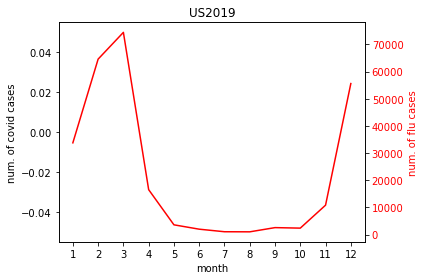

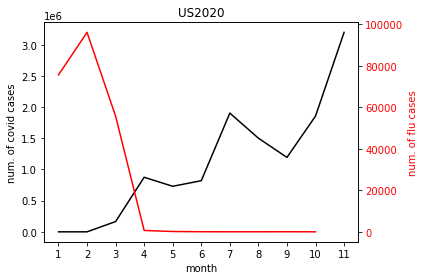

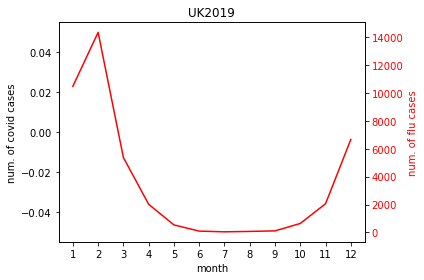

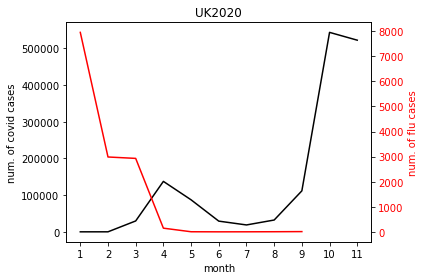

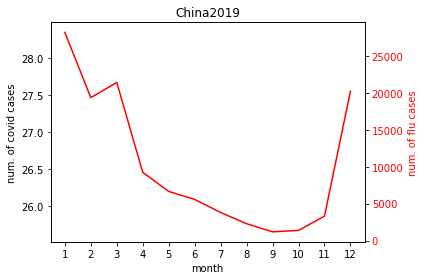

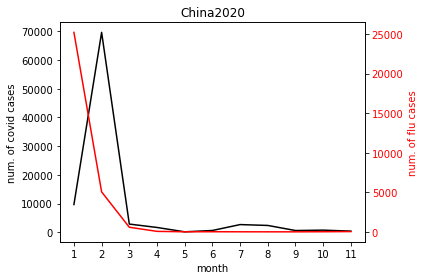

In [72]:
us_graph2019=plot_graph(us, 2019, 2020, 2)

uk_graph2019=plot_graph(uk, 2019, 2020, 2)

china_graph2019=plot_graph(china, 2019, 2020, 2)

In [18]:
#uk1516 = uk1516.drop(range(24, 48, 1))
#frames = [uk1516, uk1718]
#uk = pd.concat(frames)
#1516檔案刪掉17~20
#concat with 1718檔案

In [73]:
#Hypothesis 3:
#The peak of the spread of influenza may delay due to the pandemic since people wear masks.
# hypothesis 3 -> 2015 ~ 2019 數據疊一起看過去幾年的flu peak，2020數據也疊一起，但是用不同顏色的線表示 -> 作結論 (plot x 1)(2015~2020)
def plot_graph3(country: pd.DataFrame, startyear: int, currentyear:int):
    """
    Create plot for the hypothesis 3
    :param country: the country's data we need
    :param startyear: the first plot is from the data in startyear
    :param currentyear: the last plot is from the data in currentyear
    :return: None
    """
    plot_data = []
    flucase = []
    for i in range(startyear, currentyear + 1):
        plot_data.append(separate_data(country, i))

    # extract data from specific year
    for i in range(len(plot_data)):
        flucase.append(plot_data[i]["flu cases"])

    fig, ax1 = plt.subplots()
    plt.title('the num. of flu cases in '+country["country"][0] + ' in '+str(startyear)+'-'+str(currentyear))
    plt.xlabel('month')

    time=plot_data[0]['month']
    time20=plot_data[-1]['month']
    plt.xticks(np.arange(min(time), max(time)+1, 1.0))
    ax1.set_ylabel('num. of cases', color='black')

    for i in range(len(flucase) - 1):
        if i == 0:
            plt.plot(time, flucase[i], color='grey',label=str(startyear)+'~'+str(currentyear))
        else:
            plt.plot(time, flucase[i], color='grey')

    plt.plot(time20, flucase[-1], color='red',label='2020(with mask)')

    plt.axvline(x=4,label='April')
    if country["country"][0]=='UK':
        plt.axvline(x=6,color='orange',label='June')
        plt.text(4.3           ,7500,'2 months',fontsize=9 ,
                 bbox=dict(boxstyle="larrow,pad=0.3", fc="cyan", ec="b", lw=2))
    if country["country"][0]=='US':
        plt.axvline(x=7,color='orange',label='July')
        plt.text(4.5,45000, '3 months' , fontsize=13,
                 bbox=dict(boxstyle="larrow,pad=0.3", fc="cyan", ec="b", lw=2))



    plt.legend(loc="upper right")

    plt.show()


#us_graph3=plot_graph3(us,2015,2020)
#china_graph3=plot_graph3(china,2015,2020)
#uk_graph3=plot_graph3(uk,2015,2020)

    

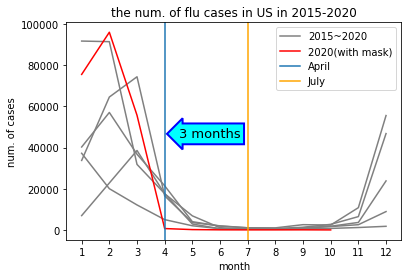

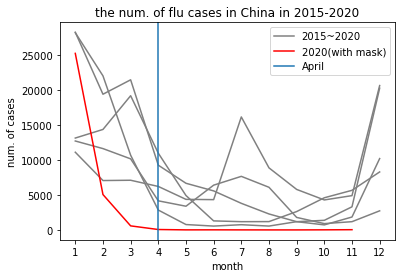

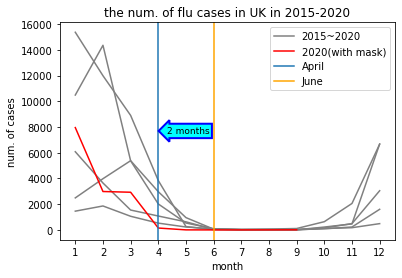

In [74]:
us_graph3=plot_graph3(us,2015,2020)
china_graph3=plot_graph3(china,2015,2020)
uk_graph3=plot_graph3(uk,2015,2020)





In [21]:
doctest.testmod()

<ipython-input-5-314ff369ee6a>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country["yearmonth"] = country["dateRep"].map(lambda dt: dt.replace(day=1))


TestResults(failed=0, attempted=10)

In [22]:
doctest.testmod()

<ipython-input-5-314ff369ee6a>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country["yearmonth"] = country["dateRep"].map(lambda dt: dt.replace(day=1))


TestResults(failed=0, attempted=10)

In [23]:
doctest.testmod()

<ipython-input-5-314ff369ee6a>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country["yearmonth"] = country["dateRep"].map(lambda dt: dt.replace(day=1))


TestResults(failed=0, attempted=10)